# Tine Series Transformer Model

In [1]:
pip install torch numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


## Data Preprocessing

In [2]:
import pandas as pd
import numpy as np

# Load Reliance.csv
data = pd.read_csv('RELIANCE.csv', parse_dates=['Date'], index_col='Date')
# Use closing prices and compute returns for volatility
prices = data['Close']
returns = prices.pct_change().dropna()

## Data Preparation

In [3]:
import numpy as np
import pandas as pd
import torch

# Synthetic time series
time = np.arange(0, 400, 0.1)
series = np.sin(0.02 * time) + 0.5 * np.random.randn(len(time))

# Create input-output sequences
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

seq_len = 20
X, y = create_sequences(series, seq_len)
X = torch.from_numpy(X).float().unsqueeze(-1)  # (batch, seq, 1)
y = torch.from_numpy(y).float().unsqueeze(-1)  # (batch, 1)


## Model Definition

In [4]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=1, num_layers=2, d_model=64,
                 nhead=4, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.src_embedding = nn.Linear(feature_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, seq_len, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        # src shape: (batch, seq_len, feature_size)
        x = self.src_embedding(src) + self.pos_encoder
        # Transformer expects (seq_len, batch, d_model)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x[-1, :, :]               # take last time step
        out = self.decoder(x)         # (batch, 1)
        return out

model = TimeSeriesTransformer()  


C:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Training Loop

In [5]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

dataset = TensorDataset(X, y)
loader  = DataLoader(dataset, batch_size=32, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss {total_loss/len(loader):.4f}")


Epoch 1, Loss 0.2948
Epoch 2, Loss 0.2898
Epoch 3, Loss 0.2755
Epoch 4, Loss 0.2761
Epoch 5, Loss 0.2727
Epoch 6, Loss 0.2717
Epoch 7, Loss 0.2695
Epoch 8, Loss 0.2725
Epoch 9, Loss 0.2774
Epoch 10, Loss 0.2686
Epoch 11, Loss 0.2697
Epoch 12, Loss 0.2678
Epoch 13, Loss 0.2673
Epoch 14, Loss 0.2659
Epoch 15, Loss 0.2658
Epoch 16, Loss 0.2700
Epoch 17, Loss 0.2646
Epoch 18, Loss 0.2671
Epoch 19, Loss 0.2641
Epoch 20, Loss 0.2642


## Evaluation

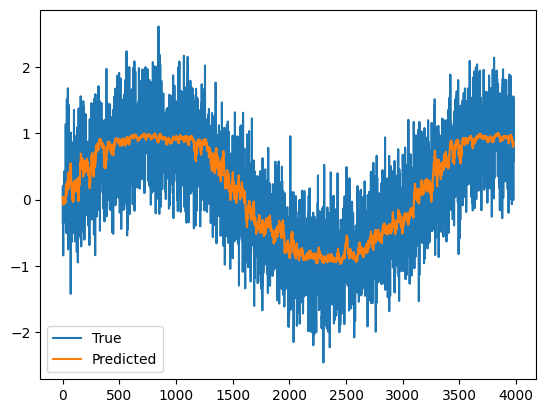

In [6]:
model.eval()
with torch.no_grad():
    preds = model(X).squeeze().numpy()
import matplotlib.pyplot as plt

plt.plot(series[seq_len:], label='True')
plt.plot(preds,    label='Predicted')
plt.legend(); plt.show()